In [1]:
%%capture
import numpy as np
import smica
import os
import json

import warnings
warnings.filterwarnings('ignore')

import copy
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp

from component_separation.io import IO
import component_separation.powerspectrum as pospec
import component_separation.map as mp
import component_separation.transformer as trsf

from component_separation.cs_util import Config
from component_separation.cs_util import Smica_bins as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Filename_gen_SMICA as fns_gen
from component_separation.cs_util import Filename_gen as fn_gen

csu = Config()
io = IO(csu)
fn = fn_gen(csu)
fns = fns_gen(csu)
tebdict = {0:'I', 1:'Q', 2:'U'}

lmax=csu.lmax
nside_out = csu.nside_out
bins = csu.bins
detector = csu.FREQ_f
specfilter = csu.specfilter
freqfilter = csu.FREQFILTER
lmaxbins = int(bins[-1][1])
colors=csu.CB_color_cycle
bcorr = [
    hp.gauss_beam(val, lmax, pol = True)[:,1]
    for val in [
        0.00930842,
        0.00785398,
        0.00378155,
        0.002807071,
        0.002106031,
        0.00145444,
        0.00140499,
        ]
    ]
beam5 = hp.gauss_beam(0.001454441043324941835, lmax, pol = True)[:,1]

In [23]:
def get_mask(freqdset, mskset, spectrum_type):
    csu = Config(freqdset=freqdset, mskset=mskset, spectrum_type=spectrum_type, verbose=False)
    fn = fn_gen(csu)
    fns = fns_gen(csu)
    io = IO(csu)
    apo = csu.spectrum_type == 'pseudo'
    tmask_fn = fn.get_mask('T', apodized=apo)
    pmask_fn = fn.get_mask('P', apodized=apo)
    tmask_sg = io.load_mask(tmask_fn, stack=True)
    pmask_sg = io.load_mask(pmask_fn, stack=True)

    tmask, pmask = dict(), dict()
    for FREQ in csu.FREQ:
        if FREQ not in csu.FREQFILTER:
            tmask[FREQ] = tmask_sg
            pmask[FREQ] = pmask_sg
    return tmask, pmask
import itertools
mask = dict()
for mskset, spectrum_type in itertools.product(['lens', 'smica'], ['pseudo', 'JC']):
    tmask, pmask = get_mask(freqdset=freqdset, mskset=mskset, spectrum_type=spectrum_type)
    if mskset in mask:
        if spectrum_type in mask[mskset]:
            mask[mskset].update({
                'T': tmask,
                 'P': pmask,
            })
        else:
            mask[mskset].update({
                spectrum_type:{
                    'T': tmask,
                     'P': pmask,
            }})
    else:
        mask.update({
            mskset:{
                spectrum_type:{
                    'T': tmask,
                     'P': pmask,
            }}})

In [30]:
mask['lens'].keys()

dict_keys(['pseudo', 'JC'])

In [19]:
smica_params = dict({'cov': None, "cov4D": None, "CMB": None, "gal_mm": None, "w": None})
smica_params = dict()
prod = [['NPIPE', 'DX12'], ['lens', 'smica'], ['pseudo', 'JC']]
dhelper = dict({'cov': None, "cov4D": None, "CMB": None, "gal_mm": None, "w": None})
lmax_loc = 4000
clmin = dict()
simid=-1
W = dict()
beamf = dict()
    
for freqdset, mskset, spectrum_type in itertools.product(*prod):
    if freqdset in smica_params:
        if mskset in smica_params[freqdset]:
                smica_params[freqdset][mskset].update({spectrum_type: dhelper})
                clmin[freqdset][mskset].update({spectrum_type: None})
        else:
            smica_params[freqdset].update({mskset:{spectrum_type: dhelper}})
            clmin[freqdset].update({mskset:{spectrum_type: None}})
    else:
        smica_params.update({freqdset: {mskset:{spectrum_type: dhelper}}})
        clmin.update({freqdset: {mskset:{spectrum_type: None}}})
    if freqdset in W:
        if mskset in W[freqdset]:
                W[freqdset][mskset].update({spectrum_type: None})
        else:
            W[freqdset].update({mskset:{spectrum_type: None}})
    else:
        W.update({freqdset: {mskset:{spectrum_type: None}}})
        
for freqdset, mskset, spectrum_type in itertools.product(*prod):
    csu = Config(freqdset=freqdset, mskset=mskset, spectrum_type=spectrum_type, verbose=False)
    fn = fn_gen(csu)
    fns = fns_gen(csu)
    bins = csu.bins
    W_smica = io.load_data(fns.get_misc('w', simid=simid))
    W_mv = io.load_data(fn.get_misc('w', simid=simid))
    
    if freqdset not in beamf:
        beamf[freqdset] = io.load_beamf(csu.freqcomb, csu.lmax, csu.freqdatsplit)
    if W_smica is not None and W_mv is not None:
        W_total = hpf.interp_smica_mv_weights(W_smica, W_mv, bins, 4001)
        W[freqdset][mskset][spectrum_type] = W_total
        W[freqdset][mskset][spectrum_type][:,:,0:2] = 0.0
    clmin[freqdset][mskset][spectrum_type] = io.load_data(fns.get_spectrum("T", "combined", simid=-1))
    for k, v in smica_params[freqdset][mskset][spectrum_type].items():
        smica_params[freqdset][mskset][spectrum_type][k] = io.load_data(fns.get_misc(k))

loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_w_SMICA_highell_bins_pseudo.npy
no existing data at /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/w_pseudo.npy
no existing data at /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/ClT_combined_SMICA_highell_bins_2048_4000_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_cov_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_cov4D_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_CMB_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_gal_mm_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_w_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_w_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/com

NPIPE lens JC (9, 4001)
DX12 lens JC (9, 4001)
DX12 smica JC (9, 4001)


Text(0.5, 0, 'Multipole')

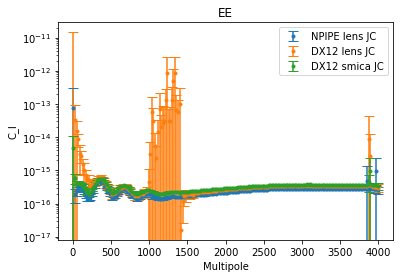

In [17]:
%matplotlib inline
EBidx = 0
nbins = 200
for freqdset, mskset, spectrum_type in itertools.product(*prod):
    if freqdset in clmin:
        if mskset in clmin[freqdset]:
            if spectrum_type in clmin[freqdset][mskset]:
                if clmin[freqdset][mskset][spectrum_type] is not None:
                    if clmin[freqdset][mskset][spectrum_type][EBidx].shape[0] == 9:
                        print(freqdset, mskset, spectrum_type, clmin[freqdset][mskset][spectrum_type][EBidx].shape)
                        mean, err, _ = hpf.std_dev_binned(clmin[freqdset][mskset][spectrum_type][EBidx][1], binwidth=nbins, lmax=4001, log=False)  
                        plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=err, label='{} {} {}'.format(freqdset,mskset, spectrum_type), fmt= '.', capsize=5)
                else:
                    pass
            else:
                pass
# mean, err, _ = hpf.std_dev_binned(ClTcombNLDS[EBidx+1], binwidth=nbins, lmax=4001, log=False)
# plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=err, label='NPIPE data with DX12-smica weights', fmt= '.', capsize=5)
# mean, err, _ = hpf.std_dev_binned(propag_smica_C_lmin_sc[EBidx], binwidth=nbins, lmax=4000, log=False)
# plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=err, label='NPIPE data with smica-propag weights', fmt= '.', capsize=5)
# plt.plot(C_lS[0,1], label='Planck best estimate')
plt.legend()
plt.yscale('log')
plt.ylabel('C_l')
if EBidx == 0:
    plt.title('EE')
else:
    plt.title('BB')
plt.xlabel('Multipole')

# MV spectrum/map for NPIPE lens with DX12 smica weights
## weights: DX12 smica

## alms: NPIPE lens
### Recalculate..

In [21]:
maps = dict()
for freqdset in ['NPIPE', 'DX12']:
    maps[freqdset] = dict()
    csu = Config(freqdset=freqdset, verbose=False)
    fn = fn_gen(csu)
    for FREQ in csu.FREQ:
        if FREQ not in csu.FREQFILTER:
            inpath_map_pla_name = fn.get_d(FREQ, "T", simid=simid)
            print("inpath_map_pla_name: {}".format(inpath_map_pla_name))
            nside_out = csu.nside_out[0] if int(FREQ)<100 else csu.nside_out[1]
            maps[freqdset][FREQ] = io.load_d(inpath_map_pla_name, field=(0,1,2), nside_out=nside_out)
    maps[freqdset] = mp.process_all(maps[freqdset])

inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_030_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_044_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_070_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_100_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_143_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_217_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_353_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/LFI_SkyMap_030_1024_R3.00_full.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/LFI_SkyMap_044_1024_R3.00_full.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/LFI_SkyMap_

# Choice No1 - MV NPIPE lens with DX12 smica weights

In [37]:
M_spectrum_type_c = 'JC'
M_maskset_c = 'lens'
M_freqdset_c = 'NPIPE'
M_mask_c = mask[M_maskset_c][M_spectrum_type_c]
maps_c = maps[M_freqdset_c]
beam = beamf[M_freqdset_c]

W_freqdset_c = 'DX12'
W_maskset_c = 'smica'
W_spectrum_type_c = 'JC'

apo = M_spectrum_type_c == 'pseudo'

## Take existing..

In [ ]:
alm = io.load_data('/global/cscratch1/sd/sebibel/compsep/misc/alm_NL.npy')
almE = alm[:,1,:]
almB = alm[:,2,:]

In [ ]:
combalm = ioc.load_data("/global/cscratch1/sd/sebibel/compsep/misc/alm_NLDS.npy")
combalmE = combalm[1]
combalmB = combalm[2]

In [ ]:
MV_map_NPlensDXsmica = io.load_data("/global/cscratch1/sd/sebibel/compsep/misc/alm_NLDS")

## ..or recalculate

In [34]:
nalm = int((lmax_loc+1)*(lmax_loc+2)/2) 
alm = np.zeros(shape=(len(csu.FREQ_f),3,nalm))
print('Calculating alms')
for itf, freq in enumerate(csu.FREQ_f):
    print('freq: ', freq)
    ns = csu.nside_out[0] if int(freq) < 100 else csu.nside_out[1]
    if apo:
        alm[itf][1:] = hp.map2alm(np.array([n*hp.ud_grade(M_mask_c['P'][freq], nside_out=ns) for n in maps_c[freq]]), lmax_loc)[1:]
    else:
        alm[itf][1:] = trsf.map2alm_spin(maps_c[freq], hp.ud_grade(M_mask_c['P'][freq], nside_out=ns), 2, lmax_loc)

freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [39]:
combalmE = np.zeros((nalm), dtype=np.complex128)
combalmB = np.zeros((nalm), dtype=np.complex128)
beam_e = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,1]
beam_b = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,2]
print('Calculating combination {}-{} data with {}-{} weights'.format(M_freqdset_c, M_maskset_c, W_freqdset_c, W_maskset_c))
for itf, det in enumerate(csu.FREQ): #weights do not depend on FREQFILTER, but almE/B do
    if det in csu.FREQ_f:
        print('freq: ', det)
        ns = csu.nside_out[0] if int(det) < 100 else csu.nside_out[1]
        # combalmT += hp.almxfl(almT[name], np.squeeze(W[0,m,:]))
        combalmE += hp.almxfl(
            hp.almxfl(
                hp.almxfl(
                    alm[itf][1], np.nan_to_num(1/beam[1,itf,itf,:lmax_loc])),
                beam_e[:lmax_loc]),
            np.squeeze(W[W_freqdset_c][W_maskset_c][W_spectrum_type_c][1,itf,:lmax_loc]))
        # combalmE = hp.almxfl(combalmE, 1/hp.pixwin(ns, pol=True)[0][:lmax_loc])
        combalmB += hp.almxfl(
            hp.almxfl(
                hp.almxfl(
                    alm[itf][2], np.nan_to_num(1/beam[2,itf,itf,:lmax_loc])),
                    beam_b[:lmax_loc]),
            np.squeeze(W[W_freqdset_c][W_maskset_c][spectrum_type_c][2,itf,:lmax_loc]))
        # combalmB = hp.almxfl(combalmB, 1/hp.pixwin(ns, pol=True)[1][:lmax_loc])

Calculating combination NPIPE-lens data with DX12-smica weights
freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [47]:
mapT_combined = hp.alm2map([np.zeros_like(combalmE), combalmE, combalmB], csu.nside_out[1])
ClTcombNLDS = trsf.map2cls({'combined':mapT_combined}, {'combined':M_mask_c['P']['030']}, {'combined':M_mask_c['P']['030']}, csu.spectrum_type, lmax_loc, freqcomb=['combined-combined'], lmax_mask=csu.lmax_mask)

## Look at the result

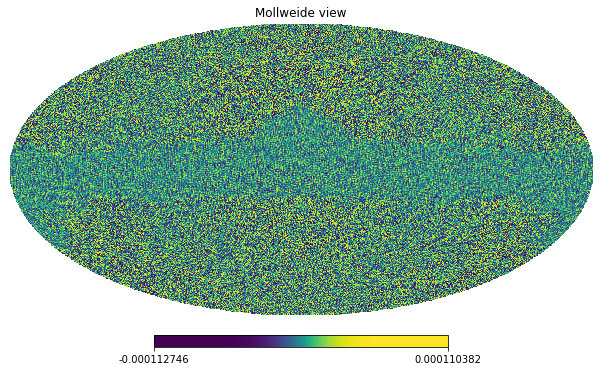

In [54]:
plt.plot(ClTcombNLDS[0,1])
plt.yscale('log')
hp.mollview(mapT_combined[1], norm='hist')

## Store the data

In [65]:
io.save_data(alm, '/global/cscratch1/sd/sebibel/compsep/misc/alm_NL.npy')

io.py: Data saved to /global/cscratch1/sd/sebibel/compsep/misc/alm_NL.npy


In [69]:
comb = np.array([np.zeros_like(combalmE), combalmE, combalmB])
io.save_data(comb, "/global/cscratch1/sd/sebibel/compsep/misc/alm_NLDS.npy")

io.py: Data saved to /global/cscratch1/sd/sebibel/compsep/misc/alm_NLDS


# Choice No2 - DX12 smica with DX12 smica weights

In [41]:
M_spectrum_type_c = 'JC'
M_freqdset_c = 'DX12'
M_maskset_c = 'smica'

maps_c = maps[M_freqdset_c]
apo = M_spectrum_type_c == 'pseudo'
M_mask_c = mask[M_maskset_c][M_spectrum_type_c]
beam = beamf[M_freqdset_c]

W_freqdset_c = 'DX12'
W_maskset_c = 'smica'
W_spectrum_type_c = 'JC'

## Take existing..

In [ ]:
almE = io.load_data('/global/cscratch1/sd/sebibel/misc/almE_Npipe_lens.npy')
almB = io.load_data('/global/cscratch1/sd/sebibel/misc/almB_Npipe_lens.npy')

combalmE_NPlensDXsmica = ioc.load_data("/global/cscratch1/sd/sebibel/misc/combalmE_Npipe_lens_DX12smicaweights.npy")
combalmB_NPlensDXsmica = ioc.load_data("/global/cscratch1/sd/sebibel/misc/combalmB_Npipe_lens_DX12smicaweights.npy")

MV_map_NPlensDXsmica = io.load_data("/global/cscratch1/sd/sebibel/misc/MVmap_Npipe_lens_DX12smicaweights.npy")

## ..or recalculate

In [70]:
nalm = int((lmax_loc+1)*(lmax_loc+2)/2) 
alm = np.zeros(shape=(len(csu.FREQ_f),3,nalm))
print('Calculating alms')
for itf, freq in enumerate(csu.FREQ_f):
    print('freq: ', freq)
    ns = csu.nside_out[0] if int(freq) < 100 else csu.nside_out[1]
    if apo:
        alm[itf][1:] = hp.map2alm(np.array([n*hp.ud_grade(M_mask_c['P'][freq], nside_out=ns) for n in maps_c[freq]]), lmax_loc)[1:]
    else:
        alm[itf][1:] = trsf.map2alm_spin(maps_c[freq], hp.ud_grade(M_mask_c['P'][freq], nside_out=ns), 2, lmax_loc)

Calculating alms
freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [71]:
combalmE = np.zeros((nalm), dtype=np.complex128)
combalmB = np.zeros((nalm), dtype=np.complex128)
beam_e = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,1]
beam_b = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,2]
print('Calculating combination {}-{} data with {}-{} weights'.format(M_freqdset_c, M_maskset_c, W_freqdset_c, W_maskset_c))
for itf, det in enumerate(csu.FREQ): #weights do not depend on FREQFILTER, but almE/B do
    if det in csu.FREQ_f:
        print('freq: ', det)
        ns = csu.nside_out[0] if int(det) < 100 else csu.nside_out[1]
        # combalmT += hp.almxfl(almT[name], np.squeeze(W[0,m,:]))
        combalmE += hp.almxfl(
            hp.almxfl(
                hp.almxfl(
                    alm[itf][1], np.nan_to_num(1/beam[1,itf,itf,:lmax_loc])),
                beam_e[:lmax_loc]),
            np.squeeze(W[W_freqdset_c][W_maskset_c][W_spectrum_type_c][1,itf,:lmax_loc]))
        # combalmE = hp.almxfl(combalmE, 1/hp.pixwin(ns, pol=True)[0][:lmax_loc])
        combalmB += hp.almxfl(
            hp.almxfl(
                hp.almxfl(
                    alm[itf][2], np.nan_to_num(1/beam[2,itf,itf,:lmax_loc])),
                    beam_b[:lmax_loc]),
            np.squeeze(W[W_freqdset_c][W_maskset_c][spectrum_type_c][2,itf,:lmax_loc]))
        # combalmB = hp.almxfl(combalmB, 1/hp.pixwin(ns, pol=True)[1][:lmax_loc])

Calculating combination DX12-smica data with DX12-smica weights
freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [72]:
mapT_combined = hp.alm2map([np.zeros_like(combalmE), combalmE, combalmB], csu.nside_out[1])
ClTcombDSDS = trsf.map2cls({'combined':mapT_combined}, {'combined':M_mask_c['P']['030']}, {'combined':M_mask_c['P']['030']}, csu.spectrum_type, lmax_loc, freqcomb=['combined-combined'], lmax_mask=csu.lmax_mask)

## Look at the result

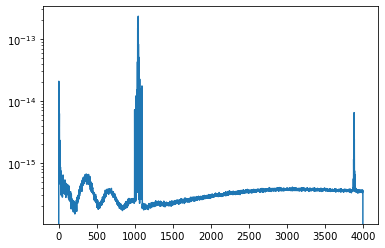

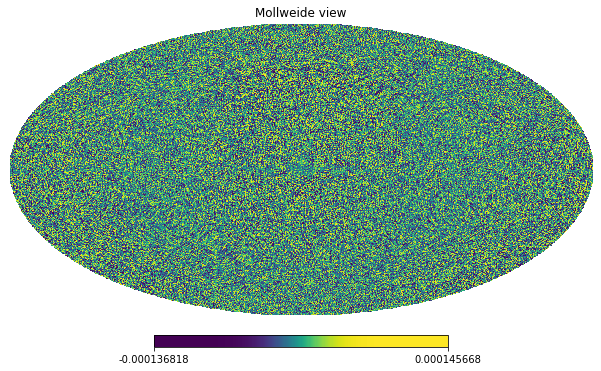

In [73]:
plt.plot(ClTcombDSDS[0,1])
plt.yscale('log')
plt.show()
hp.mollview(mapT_combined[1], norm='hist')

## Store the data

In [96]:
io.save_data(alm, '/global/cscratch1/sd/sebibel/compsep/misc/alm_DS.npy')
comb = np.array([np.zeros_like(combalmE), combalmE, combalmB])
io.save_data(comb, "/global/cscratch1/sd/sebibel/compsep/misc/alm_DSDS.npy")

io.py: Data saved to /global/cscratch1/sd/sebibel/compsep/misc/alm_DS.npy
io.py: Data saved to /global/cscratch1/sd/sebibel/compsep/misc/alm_DSDS.npy


# Variance

In [87]:
ll = np.arange(0,4001,1)
EBidx=1
approx_variance_NLDS = 2 * ClTcombNLDS[0,EBidx,:] * ClTcombNLDS[0,EBidx,:]/((2*ll+1)*0.67)
approx_variance_DSDS = 2 * ClTcombDSDS[0,EBidx,:] * ClTcombDSDS[0,EBidx,:]/((2*ll+1)*0.97)
# approx_variance_NPpropag = 2 * propag_smica_C_lmin_sc[EBidx,:] * propag_smica_C_lmin_sc[EBidx,:]/((2*ll+1)*0.67)

Text(0.5, 1.0, 'Comparing Variance of MV spectra')

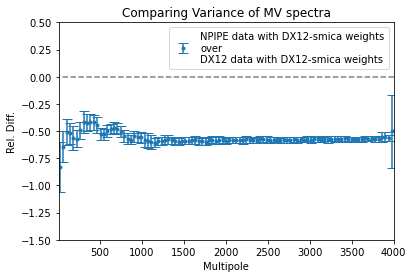

In [92]:
%matplotlib inline
# plt.plot(approx_variance_NPDXsmica)
# plt.plot(approx_variance_NPlens)

# plt.plot(approx_variance_NPlens/approx_variance_NPDXsmica-1, label= 'NPIPE data with NPIPE-lens weights\nover\nNPIPE data with DX12-smica weights')
# plt.plot(approx_variance_NPlens/approx_variance_NPpropag-1, label= 'NPIPE data with NPIPE-lens weights\nover\nNPIPE data with smica-propag weights')
mean, std, _ = hpf.std_dev_binned(approx_variance_NLDS/approx_variance_DSDS-1, lmax=4001, binwidth=100, log=False)
plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=std, fmt='.', capsize=5, label= 'NPIPE data with DX12-smica weights\nover\nDX12 data with DX12-smica weights')
# mean, std, _ = hpf.std_dev_binned(approx_variance_NPlens/approx_variance_NPpropag-1, lmax=4000, binwidth=100, log=False)
# plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=std, fmt='.', capsize=5, label= 'NPIPE data with NPIPE-lens weights\nover\nNPIPE data with smica-propag weights')

# mean, std, _ = hpf.std_dev_binned(NP_lensclmin[EBidx,:]/smica_C_lmin_sc[EBidx,:]-1, lmax=4000, binwidth=50, log=False)
# plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=std, fmt='.', capsize=5, label= 'NPIPE data with NPIPE-lens weights\nover\nNPIPE data with DX12-smica weights')
# mean, std, _ = hpf.std_dev_binned(NP_lensclmin[EBidx,:]/propag_smica_C_lmin_sc[EBidx,:]-1, lmax=4000, binwidth=50, log=False)
# plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=std, fmt='.', capsize=5, label= 'NPIPE data with NPIPE-lens weights\nover\nNPIPE data with smica-propag weights')


plt.hlines(0,lmax,0, ls='--', color= 'gray')
plt.ylim((-1.5,0.5))
# plt.yscale('log')
plt.xlim((1e1,4e3))
plt.legend()
plt.xlabel('Multipole')
plt.ylabel('Rel. Diff.')
plt.title('Comparing Variance of MV spectra')
# plt.yscale('log')

# Backup

## Check Weights

In [6]:
W_total_propag = np.loadtxt("/global/homes/s/sebibel/ext/smica_propagation/weights_EB_smica_R3.00.txt").reshape(2,7,4001)

In [3]:
cfc = copy.deepcopy(csu.cf)
cfc['pa']['freqdset'] = 'NPIPE'
cfc['pa']['mskset'] = 'lens'
csuc = Config(cfc)
ioc = IO(csuc) 

W_smica_NPlens = ioc.load_data(ioc.fh.weight_smica_path_name)
W_mv_NPlens = ioc.load_data(ioc.fh.weight_path_name)
W_total_NPlens = hpf.interp_smica_mv_weights(W_smica_NPlens, W_mv_NPlens, bins, 4001)

cfc['pa']['freqdset'] = 'DX12'
cfc['pa']['mskset'] = 'smica'
csuc = Config(cfc)
ioc = IO(csuc) 

W_smica_DXsmica = ioc.load_data(ioc.fh.weight_smica_path_name)
W_mv_DXsmica = ioc.load_data(ioc.fh.weight_path_name)
W_total_DXsmica = hpf.interp_smica_mv_weights(W_smica_DXsmica, W_mv_DXsmica, bins, 4001)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Run with the following settings:
{'Tscale': 'K_CMB', 'mskset': 'lens', 'freqdset': 'NPIPE', 'Spectrum_scale': 'C_l', 'lmax': 4000, 'lmax_mask': 6000, 'freqdatsplit': '', 'smoothing_window': 0, 'max_polynom': 0, 'num_sim': 5, 'binname': 'SMICA_highell_bins', 'overwrite_cache': True, 'split': '', 'nside_out': None, 'splitvariation': 'GHz', 'freqfilter': ['545', '857'], 'specfilter': ['TB', 'EB', 'ET', 'BT', 'BE'], 'nside_desc_map': [1024, 2048]}
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
loaded /global/cscratch1/sd/sebibel/smica/SMICAWEIG_K_CMB_SMICA_highell_bins0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/weights/NPIPE/WEIG_K_CMB_0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Run with the following settings:
{'Tscale': 'K_CMB', 'mskset': 'smica', 'freqdset': 'DX12', 'Spectrum_scale': 'C_l', 'lmax': 4000, 'lmax_mask': 6000, 'freqdatsplit': '', 'smoothing_window': 0, 'max_polynom'

In [10]:
%matplotlib widget
from scipy.signal import savgol_filter as sf
W_total_propag = np.loadtxt("/global/homes/s/sebibel/ext/smica_propagation/weights_EB_smica_R3.00.txt").reshape(2,7,4001)
# *bcorr[freq]/(beam5)
lab1='NPIPE lens'
lab2='DX12 smica'
plt.plot(0,0,color='black', label= 'NPIPE lens')
plt.plot(0,0,color='black', label= 'DX12 smcia', ls = '--')
conc=[]
lab=[]

c2 = np.sum(W_total_propag[0,:,:]*np.diagonal(np.nan_to_num(beamfNPIPE[1,:,:]),axis1=0, axis2=1).T/hp.gauss_beam(np.radians(4.845/60), lmax, pol = True)[:,1], axis=0)
c3 = np.sum(W_total_propag[0,:,:]*np.diagonal(np.nan_to_num(beamfDX12[1,:,:]),axis1=0, axis2=1).T/hp.gauss_beam(np.radians(4.848/60), lmax, pol = True)[:,1], axis=0)

Egauss = hp.gauss_beam(np.radians(4.847/60), lmax, pol = True)[:,1]
for freq in range(3,7):
    a, = plt.plot(W_total_NPlens[1,freq,:], color=colors[freq], lw = 2)
    plt.plot(W_total_DXsmica[1,freq,:], color=colors[freq], ls = '--', lw = 1)

    conc += [a]
    lab += [csu.PLANCKMAPFREQ[freq]]
    
l2 = plt.legend(conc, lab, loc=4)
plt.gca().add_artist(l2)

plt.xlabel('Multipole')
plt.ylabel('Weight')
plt.legend(loc=1)
plt.ylim((-.2,1.02))
plt.title('Comparing impact of masks and dataset on weights')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Comparing impact of masks and dataset on weights')